In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")



In [116]:
import statsmodels.api as sm
import itertools

def split_data(df,pct):
    train_data, test_data = df[0:int(len(df)*pct)], df[int(len(df)*pct):]
    
    return training_data, testing_data
    
def evaluate_SARIMAX_aic(data, max_p,max_d,max_q,min_p=0,min_d=0,min_q=0):
    p,d,q = range(min_p,max_p+1),range(min_d,max_d+1),range(min_q,max_q+1)
    pdq = list(itertools.product(p,d,q))
    seasonal_pdq = [(x[0],x[1],x[2],12) for x in pdq]

    min_aic = float("inf")
    ans_pdq = (0,0,0)
    ans_sea_pdq = (0,0,0,0)
    for param in pdq:
        for param_sea in seasonal_pdq:
            mod = sm.tsa.statespace.SARIMAX(data,
                                           order = param,
                                           seasonal_order = param_sea,
                                           enforce_stationarity = False,
                                           enforce_invertibility = False)
            result = mod.fit()
            if result.aic < min_aic:
                min_aic = result.aic
                ans_pdq = param
                ans_sea_pdq = param_sea
            print(f"SARIMA{param}x{param_sea} - AIC:{result.aic}")
            
    return ans_pdq,ans_sea_pdq
    
def evaluate_ARIMA_aic(data, max_p,max_d,max_q,min_p=0,min_d=0,min_q=0):
    p,d,q = range(min_p,max_p+1),range(min_d,max_d+1),range(min_q,max_q+1)
    pdq = list(itertools.product(p,d,q))

    min_aic = float("inf")
    ans_pdq = (0,0,0)

    for param in pdq:
        try:
            mod = ARIMA(data,
                       order = param
                       )
            result = mod.fit()

            if result.aic < min_aic:
                min_aic = result.aic
                ans_pdq = param

            print(f"ARIMA{param}- AIC:{result.aic}")
        except:
            continue
    print(f"ARIMA{ans_pdq} is the optimal params!")
    return ans_pdq

        

<AxesSubplot:>

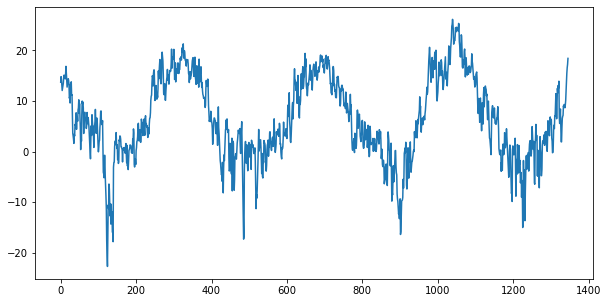

In [113]:
# input data file
data = pd.read_csv("data/weather_data_test.csv",parse_dates = ['datetime'],sep = ";",decimal = ",",infer_datetime_format = True)
data = data[["datetime","T_mu"]]
data.head()
data.shape
data.describe()
data["T_mu"].plot(figsize = (10,5))

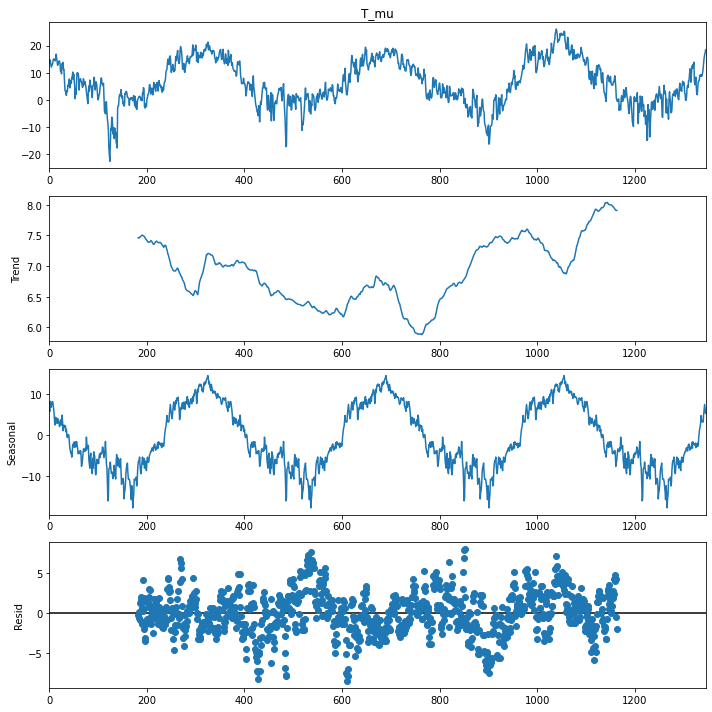

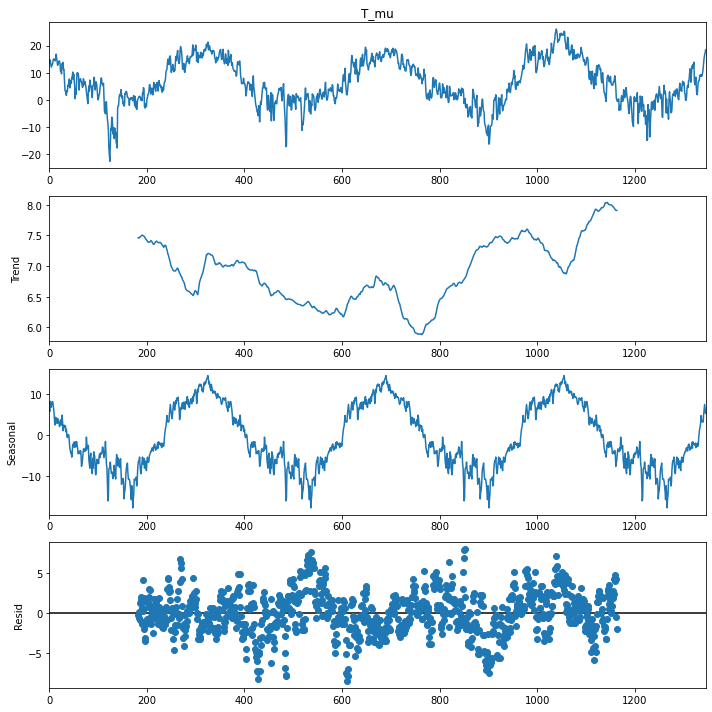

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
decom_result = seasonal_decompose(data["T_mu"],model = "additive",period = 365)
decom_result.plot()



In [10]:
#plot pacf
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
#plot_pacf(data["T_mu"], alpha=0.1, lags=20)

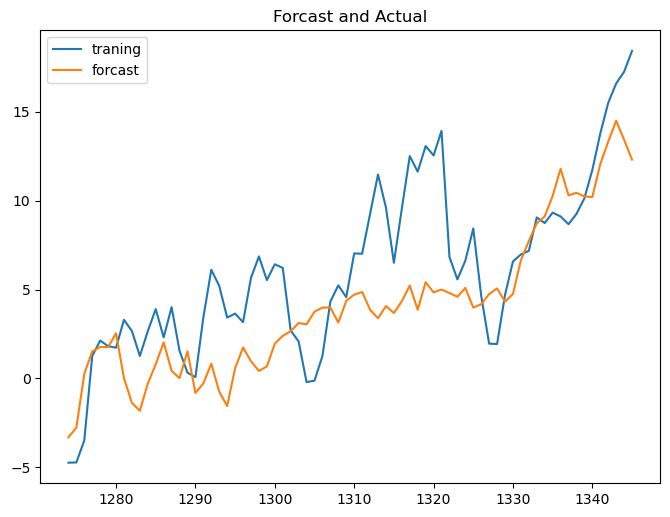

In [136]:
# use decomposed seasonal data to remove seasonality, and apply the remaining data into ARIMA model

pct = (len(data)-24*3)/len(data)
training_rem_sea = data["T_mu"]-decom_result.seasonal
train_data, test_data = training_rem_sea[0:int(len(training_rem_sea)*pct)], training_rem_sea[int(len(training_rem_sea)*pct):]


#evaluate_ARIMA_aic(train_data, 5,2,5,min_p=0,min_d=0,min_q=0)
mod = ARIMA(train_data,
       order = (3,0,4))

results=mod.fit()

fc, se, conf = results.forecast(len(test_data), alpha = 0.05)

season_part = [decom_result.seasonal[x%365] for x in test_data.index]
for i in range(len(fc)):
    fc[i]+=season_part[i]


fc_series = pd.Series(fc,index = test_data.index)
lower_series = pd.Series(conf[:,0],index = test_data.index)
upper_series = pd.Series(conf[:,1],index = test_data.index)
plt.figure(figsize = (8,6),dpi=100)
plt.plot(data[test_data.index[0]:]["T_mu"], label = "traning")
#plt.plot(test_data, label = "actual")
plt.plot(fc_series, label = "forcast")
#plt.fill_between(lower_series.index,lower_series,upper_series,color = 'k',alpha = 0.15)
plt.title("Forcast and Actual")
plt.legend(loc = "best")
plt.show()

In [137]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1274
Model:                     ARMA(3, 4)   Log Likelihood               -2731.135
Method:                       css-mle   S.D. of innovations              2.063
Date:                Thu, 03 Feb 2022   AIC                           5480.269
Time:                        13:41:31   BIC                           5526.619
Sample:                             0   HQIC                          5497.677
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.0499      0.333     21.175      0.000       6.397       7.702
ar.L1.y        0.2586      0.058      4.486      0.000       0.146       0.372
ar.L2.y       -0.3774      0.061     -6.181      0.000      -0.497      -0.258
ar.L3.y        0.7180      0.048     14.973      0.000       0.624       0.812
ma.L1.y        0.6069      0.064      9.488      0.000       0.482       0.732
ma.L2.y        0.8329      0.079     10.507      0.000       0.678       0.988
ma.L3.y       -0.0199      0.054     -0.367      0.713      -0.126       0.086
ma.L4.y       -0.1026      0.039     -2.661      0.008      -0.178      -0.027
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.3356           -1.0252j            1.0787           -0.3004
AR.2           -0.3356           +1.0252j            1.0787            0.3004
AR.3            1.1969           -0.0000j            1.1969           -0.0000
MA.1           -0.3051           -0.9978j            1.0434           -0.2972
MA.2           -0.3051           +0.9978j            1.0434            0.2972
MA.3           -2.7914           -0.0000j            2.7914           -0.5000
MA.4            3.2073           -0.0000j            3.2073           -0.0000
-----------------------------------------------------------------------------
"""

In [138]:
evaluation = data["T_mu"].iloc[fc_series.index[0]:]-fc_series
evaluation[abs(evaluation)<=5]
print(f"The prediction accurate is {len(evaluation[abs(evaluation)<=5])/len(evaluation)}")

The prediction accurate is 0.8194444444444444


In [96]:
# use ARIMA model to predict directly
data = pd.read_csv("data/weather_data_test.csv",parse_dates = ['datetime'],sep = ";",decimal = ",",infer_datetime_format = True)
data = data[["datetime","T_mu"]]
pct = (len(data)-24*2)/len(data)
train_data, test_data = data[0:int(len(data)*pct)], data[int(len(data)*pct):]
training_data = train_data["T_mu"].values
testing_data = test_data["T_mu"].values

mod = ARIMA(training_data,
       order = (1,0,0))

#mod = sm.tsa.statespace.SARIMAX(train_data["T_mu"],
#                               order = (1,0,0),
#                               seasonal_order = (1,0,0,365),
 #                              enforce_stationarity = False,
 #                              enforce_invertibility = False)

results=mod.fit()


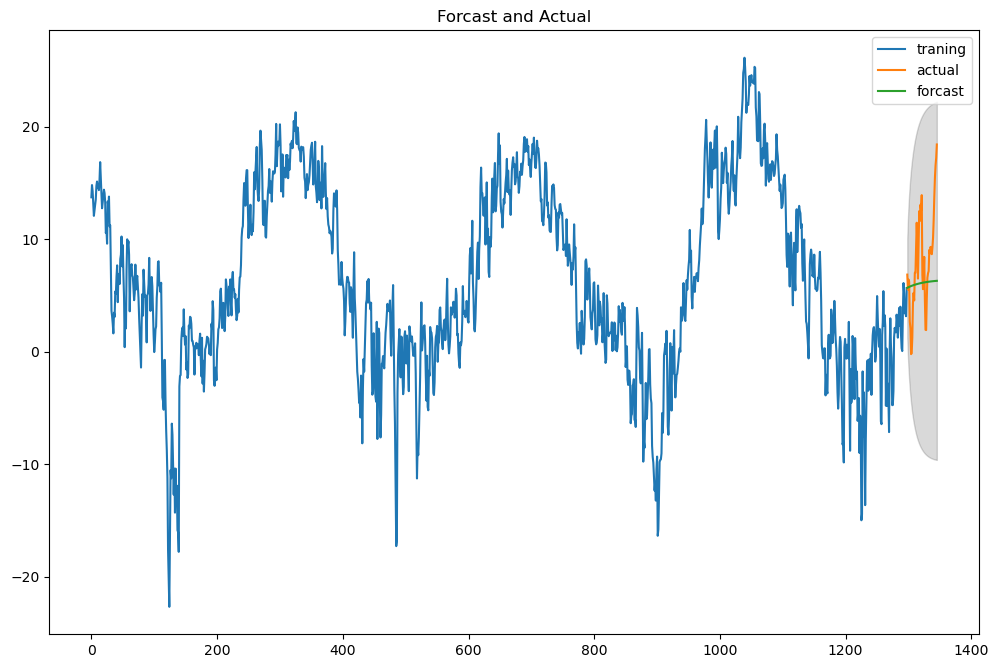

In [97]:

fc, se, conf = results.forecast(len(test_data), alpha = 0.05)
fc_series = pd.Series(fc,index = test_data.index)
lower_series = pd.Series(conf[:,0],index = test_data.index)
upper_series = pd.Series(conf[:,1],index = test_data.index)
plt.figure(figsize = (12,8),dpi=100)
plt.plot(training_data, label = "traning")
plt.plot(test_data["T_mu"], label = "actual")
plt.plot(fc_series, label = "forcast")
plt.fill_between(lower_series.index,lower_series,upper_series,color = 'k',alpha = 0.15)
plt.title("Forcast and Actual")
plt.legend(loc = "best")
plt.show()

In [98]:
evaluation = data["T_mu"].iloc[fc_series.index[0]:]-fc_series
evaluation[abs(evaluation)<=5]
print(f"The prediction accurate is {len(evaluation[abs(evaluation)<=5])/len(evaluation)}")

The prediction accurate is 0.7083333333333334


In [41]:
# predict with Seasonal ARIMA model

pct = 0.8
train_data, test_data = data[0:int(len(data)*pct)], data[int(len(data)*pct):]
training_data = train_data["T_mu"].values
testing_data = test_data["T_mu"].values



mod = sm.tsa.statespace.SARIMAX(train_data["T_mu"],
                               order = (1,0,0),
                               seasonal_order = (1,0,0,365),
                               enforce_stationarity = False,
                               enforce_invertibility = False)

results=mod.fit()


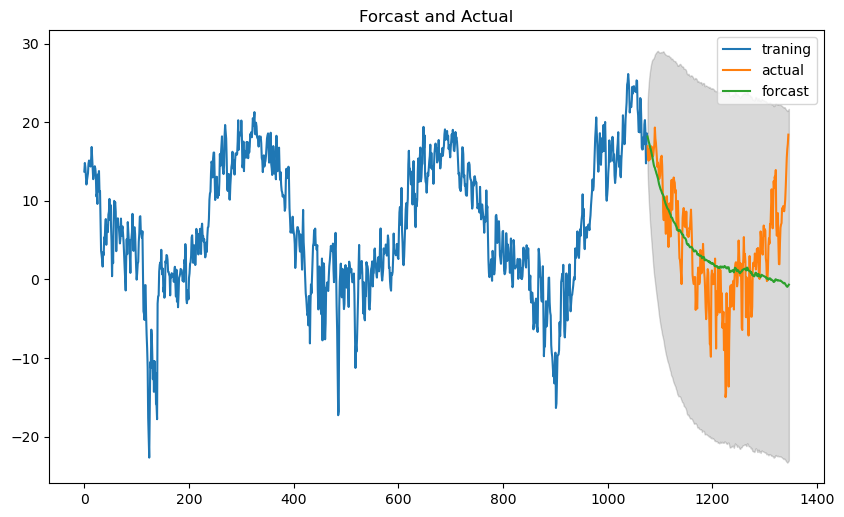

In [42]:

pred = results.get_prediction(start = int(len(data)*pct), end = len(data), dynamic= True)  
pred_conf = pred.conf_int()
pred_mean = pred.predicted_mean

new_predict = data
new_predict['forecast'] = pred_mean

plt.figure(figsize = (10,6),dpi=100)
plt.plot(training_data, label = "traning")
plt.plot(test_data["T_mu"], label = "actual")
plt.plot(pred.predicted_mean, label = "forcast")
plt.fill_between(pred_conf.index,pred_conf["lower T_mu"],pred_conf["upper T_mu"],color = 'k',alpha = 0.15)
plt.title("Forcast and Actual")
plt.legend(loc = "best")
plt.show()
